In [1]:
from functools import partial
import logging
from collections import OrderedDict

import numpy as np
from osgeo import gdal
%pylab inline
import matplotlib
import matplotlib.pyplot as plt

import proxmin
from proxmin import nmf
import dc

plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.DEBUG)

Populating the interactive namespace from numpy and matplotlib


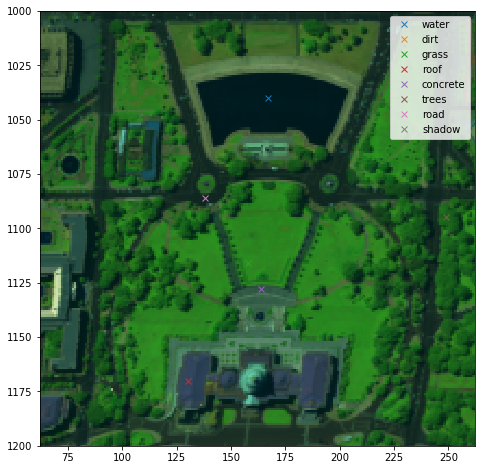

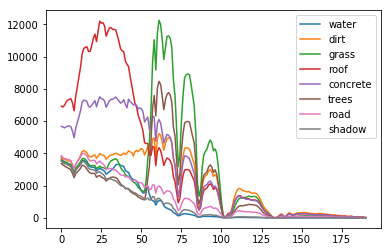

In [2]:
ds = gdal.Open('/Users/fred/Downloads/Hyperspectral_Project/dc.tif')
data_shape = ds.GetRasterBand(1).ReadAsArray().shape

# only use a subset of the image
shape = (ds.RasterCount, data_shape[0]*data_shape[1])
points = dc.ref_points

# Get hyperspectral data
data = np.zeros(shape)
for bidx in range(shape[0]):
    band = ds.GetRasterBand(bidx + 1).ReadAsArray()
    data[bidx] = band.flatten()
dc.plot_color_img(data, data_shape, figsize=(8,8), show=False);

points = OrderedDict([
    ('water', (167, 1040)),
    ('dirt', (132, 272)),
    #('dirt', (207, 1021)),
    ('grass', (158, 1116)),
    #('grass', (166, 1105)),
    ('roof', (130, 1170)),
    #('concrete', (156, 1170)),
    #('concrete', (167, 1023)),
    ('concrete', (164, 1128)),
    #('trees', (249, 1123)),
    ('trees', (249, 1095)),
    #('road', (138, 1086)),
    #('road', (175, 1196)),
    ('road', (138, 1086)),
    ('shadow', (175, 465))
    #('shadow', (70, 1160))
])

spectra = OrderedDict()
for obj, pt in points.items():
    plt.plot(pt[0], pt[1],'x', label=obj)
    spectra[obj] = dc.get_point_spec(pt[0], pt[1], data, data_shape)
plt.legend()
plt.xlim([62,262])
plt.ylim([1200,1000])
plt.show()

for obj, pt in points.items():
    plt.plot(spectra[obj], label=obj)
plt.legend()
plt.show()

# Get wavelengths used in hyperspectral data
wavelength_data = np.recfromcsv('/Users/fred/Downloads/Hyperspectral_Project/wavelengths.txt', delimiter=" ")
wavelength = wavelength_data["wavelength"]
idx = wavelength_data["idx"]

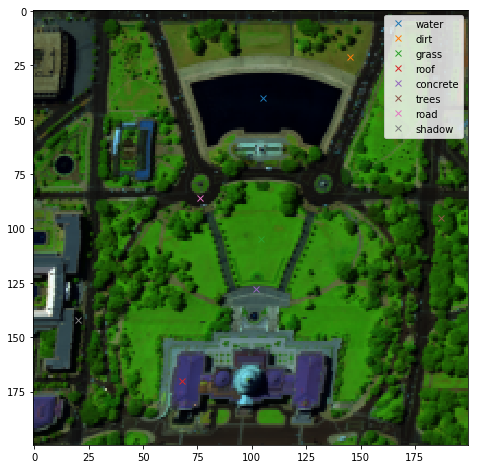

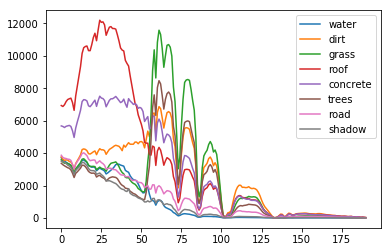

In [3]:
# only use a subset of the image
xmin = 62
xmax = 262
ymin = 1000
ymax = 1200
img_shape = (ymax-ymin, xmax-xmin)
subset = data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,ymin:ymax, xmin:xmax]
subset = subset.reshape(data.shape[0], img_shape[0]*img_shape[1])
dc.plot_color_img(subset, img_shape, show=False)

test_spectra = {}
for obj, pt in dc.ref_points.items():
    plt.plot(pt[0], pt[1],'x', label=obj)
    test_spectra[obj] = dc.get_point_spec(pt[0], pt[1], subset, img_shape)
plt.legend()
plt.show()

for obj, pt in points.items():
    plt.plot(test_spectra[obj], label=obj)
plt.legend()
plt.show()

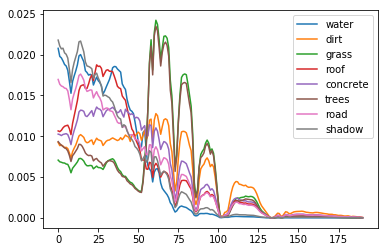

In [4]:
def init_nmf(data, img_shape, points, spec):
    """Initialize A0 and S0 using the reference points
    """
    A0 = np.zeros((data.shape[0], len(points)))
    S0 = np.zeros((len(points), img_shape[0]*img_shape[1]))

    for idx, (obj,(x,y)) in enumerate(points.items()):
        A0[:, idx] = spec[obj]
        S0[idx, y*img_shape[1]+x] = data[idx, y*img_shape[1]+x]
    norm = np.sum(A0, axis=0)
    A0 = A0/norm
    for idx, (obj,(x,y)) in enumerate(points.items()):
        plt.plot(A0[:, idx], label=obj)
    plt.legend()
    plt.show()
    return A0, S0

points = dc.ref_points
#if "shadow" in points:
#    del points["shadow"]
A0,S0 = init_nmf(subset, img_shape, points, spectra)
Ls = [[np.ones((1,A0.shape[0]))], [None]]

prox_A = proxmin.operators.prox_plus
prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]
#steps_g = [[1e-5],[None]]
#norm_L2 = [[np.array([50])], [1]]

In [5]:
import scipy.sparse
def prox_bkg(X, step, bidx=-1):
    """Use a constant background
    """
    X[bidx] = np.mean(X[bidx])
    return X

def prox_bkg_plus(X, step, bidx=-1):
    X = prox_bkg(X, step, bidx)
    X = proxmin.operators.prox_plus(X, step)
    return X

prox_g = partial(prox_bkg_plus, bidx=-1)

L = float(proxmin.utils.get_spectral_norm(A0))
print(L)
prox_S = partial(proxmin.nmf.prox_likelihood_S, A=A0, Y=subset, prox_g=prox_g)
S0 = proxmin.algorithms.apgm(X0=S0, prox_f=prox_S, step_f=.5/L, max_iter=10)

0.08352305690303014


INFO:proxmin.algorithms:Completed 10 iterations


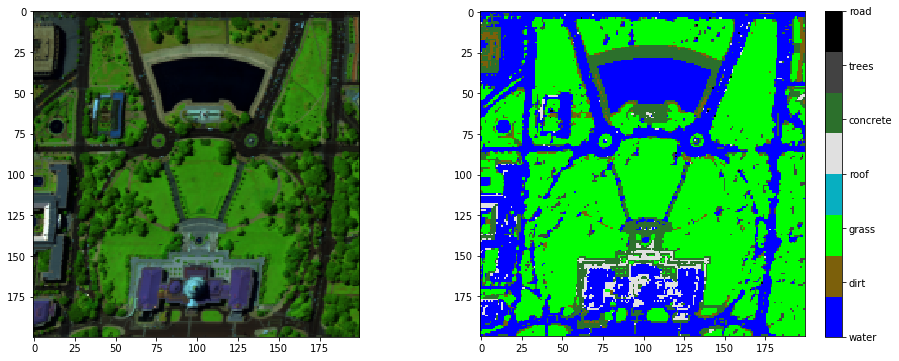

In [6]:
dc.compare_likelihood(subset, img_shape, S0, points, figsize=(16,6))

In [ ]:
Ls = [[None], [scipy.sparse.identity(A0.shape[1])]]
prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]


Ls = [[np.ones((1,A0.shape[0]))], [None]]
prox_A = proxmin.operators.prox_plus
prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]

In [7]:
A, S, hist = nmf.nmf(subset,A0, S0,
                     prox_A=prox_A,
                     Ls=Ls,
                     proxs_g=prox_g,
                     max_iter=200, 
                     traceback=True,
                     #steps_g=steps_g
                     #norm_L2 = norm_L2
                     #slack=.1
                    )

TypeError: object of type 'functools.partial' has no len()

U Total (in all steps, should be zero for S) 0.0
R total (in all steps, should be zero for S) 0.0


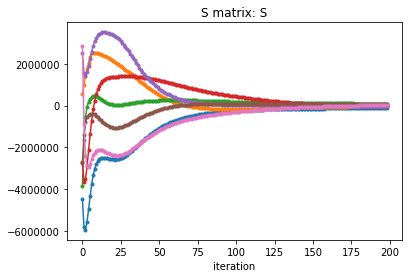

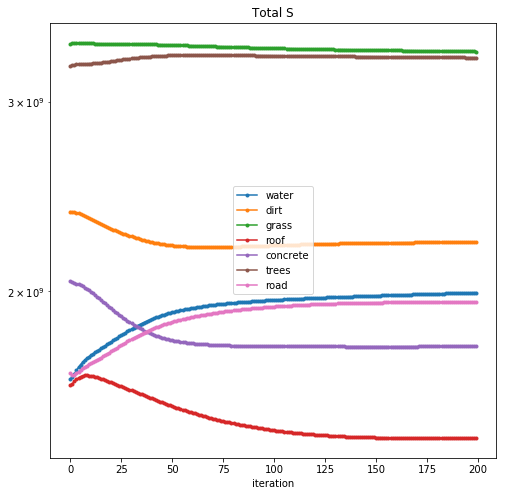

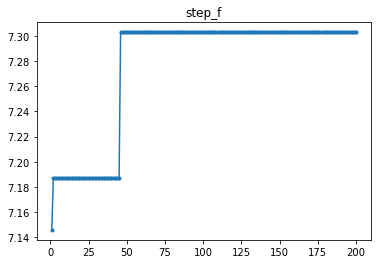

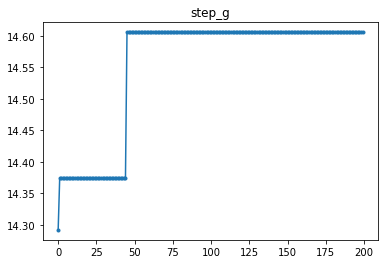

In [8]:
# S matrix history

print("U Total (in all steps, should be zero for S)", np.sum(hist["U", 1][1:-1]))
print("R total (in all steps, should be zero for S)", np.sum(hist["R", 1][1:-1]))
plt.plot(np.sum(hist["S", 1][1:-1], axis=2), '.-')
plt.title("S matrix: S")
plt.xlabel("iteration")
plt.show()

plt.figure(figsize=(8,8))
plt.title("Total S")
plt.xlabel("iteration")
total_S = np.sum(hist["X",1][:-1], axis=2)

for idx in range(total_S.shape[1]):
    plt.semilogy(total_S[:,idx], '.-', label=list(points.keys())[idx])
plt.legend()
plt.show()

plt.plot(hist["steps_f", 1], '.-')
plt.title("step_f")
plt.show()

plt.plot(hist["steps_g", 1][1:], '.-')
plt.title("step_g")
plt.show()

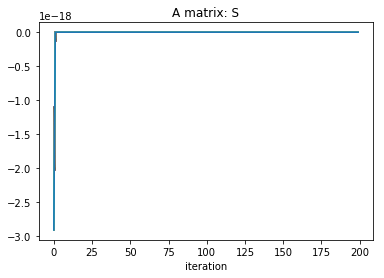

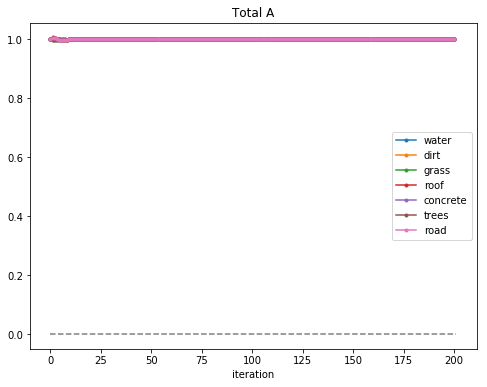

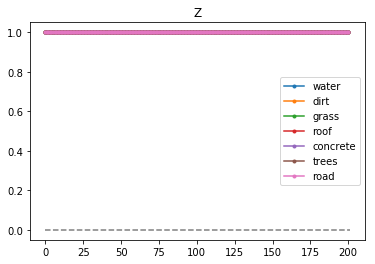

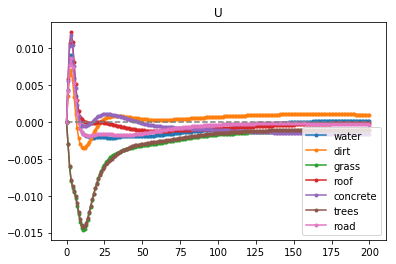

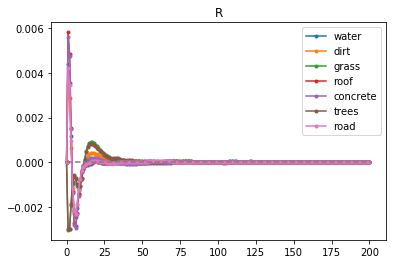

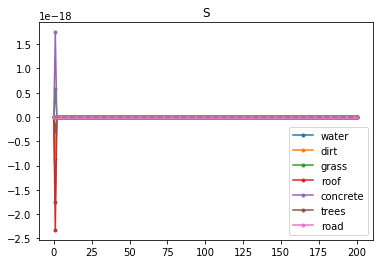

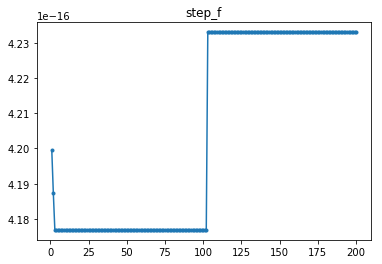

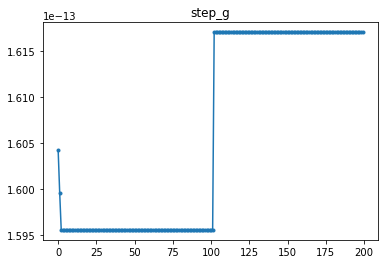

In [9]:
# A matrix history
plt.plot(np.sum(hist["S"][1:], axis=2))
plt.title("A matrix: S")
plt.xlabel("iteration")
plt.show()

plt.figure(figsize=(8,6))
plt.title("Total A")
plt.xlabel("iteration")
total_A = np.sum(hist["X"], axis=1)

for idx in range(total_A.shape[1]):
    plt.plot(total_A[:,idx], '.-', label=list(points.keys())[idx])
plt.plot([0,len(total_A)], [0,0], '--')
plt.legend()
plt.show()

Az = hist["Z"][:,0,:]
plt.title("Z")
for idx in range(Az.shape[1]):
    plt.plot(Az[:,idx], '.-', label=list(points.keys())[idx])
plt.plot([0,len(Az)], [0,0], '--')
plt.legend()
plt.show()

Au = hist["U"][:,0,:]
plt.title("U")
for idx in range(Au.shape[1]):
    plt.plot(Au[:,idx], '.-', label=list(points.keys())[idx])
plt.plot([0,len(Au)], [0,0], '--')
plt.legend()
plt.show()

Ar = hist["R"][:,0,:]
plt.title("R")
for idx in range(Ar.shape[1]):
    plt.plot(Ar[:,idx], '.-', label=list(points.keys())[idx])
plt.plot([0,len(Ar)], [0,0], '--')
plt.legend()
plt.show()

As = hist["S"][:,0,:]
plt.title("S")
for idx in range(As.shape[1]):
    plt.plot(As[:,idx], '.-', label=list(points.keys())[idx])
plt.plot([0,len(As)], [0,0], '--')
plt.legend()
plt.show()

#plt.semilogy(hist["steps_f"], '.-')
plt.plot(hist["steps_f"], '.-')
plt.title("step_f")
plt.show()

#plt.semilogy(hist["steps_g"][1:], '.-')
plt.plot(hist["steps_g"][1:], '.-')
plt.title("step_g")
plt.show()

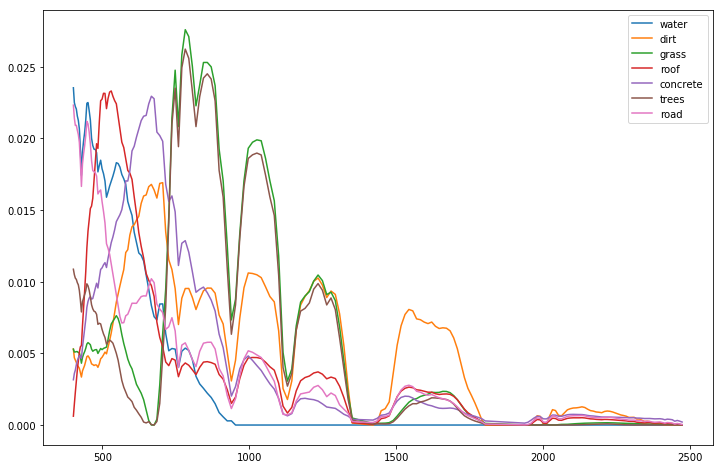

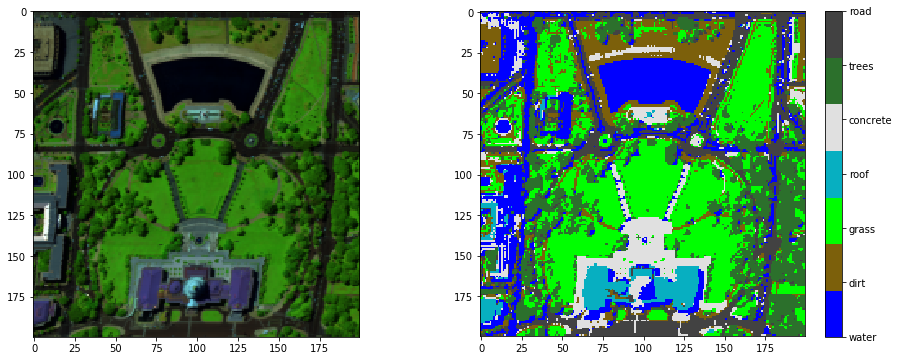

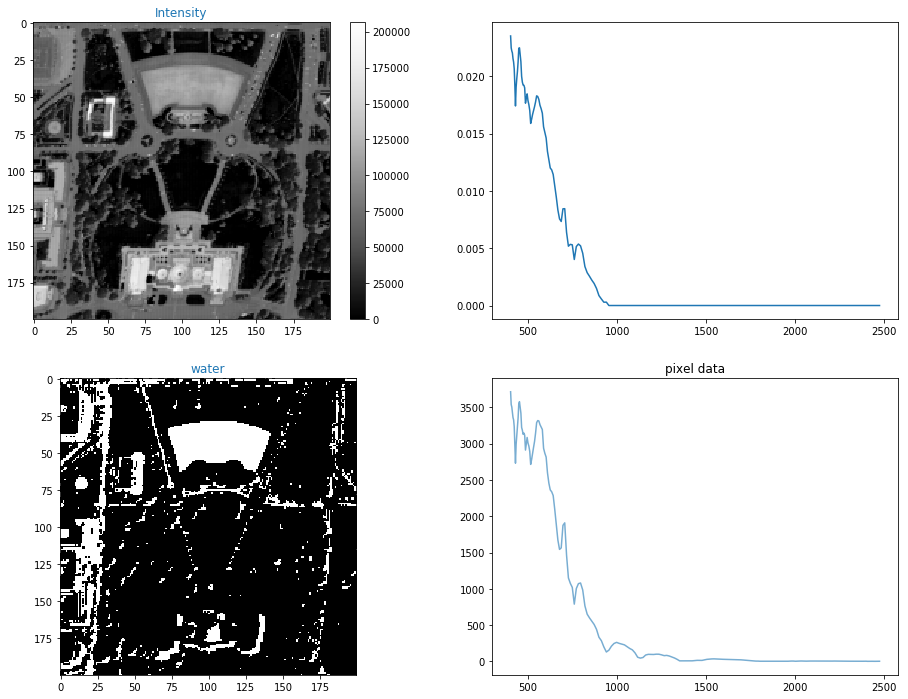

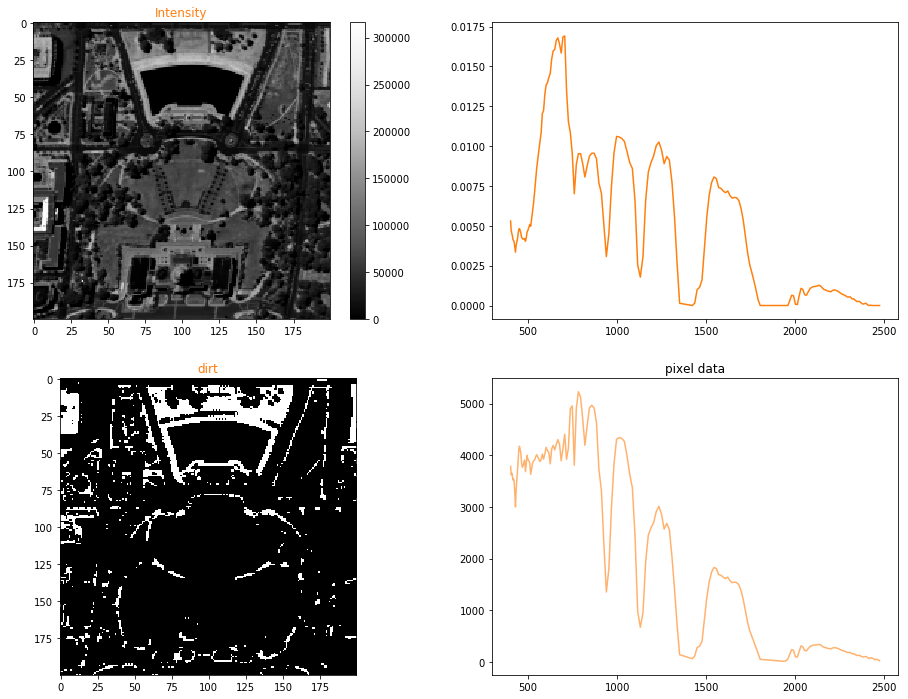

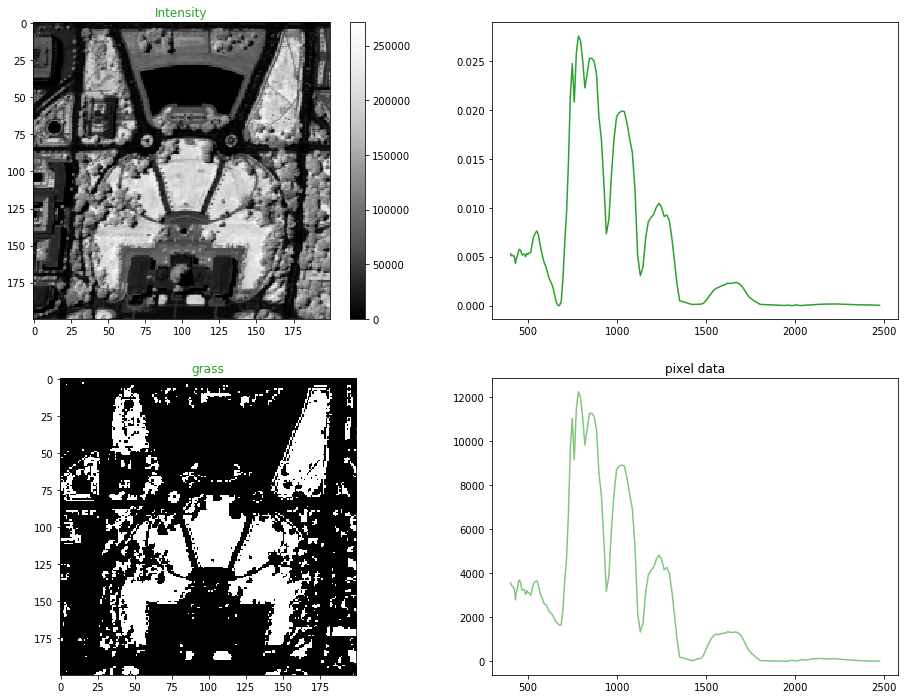

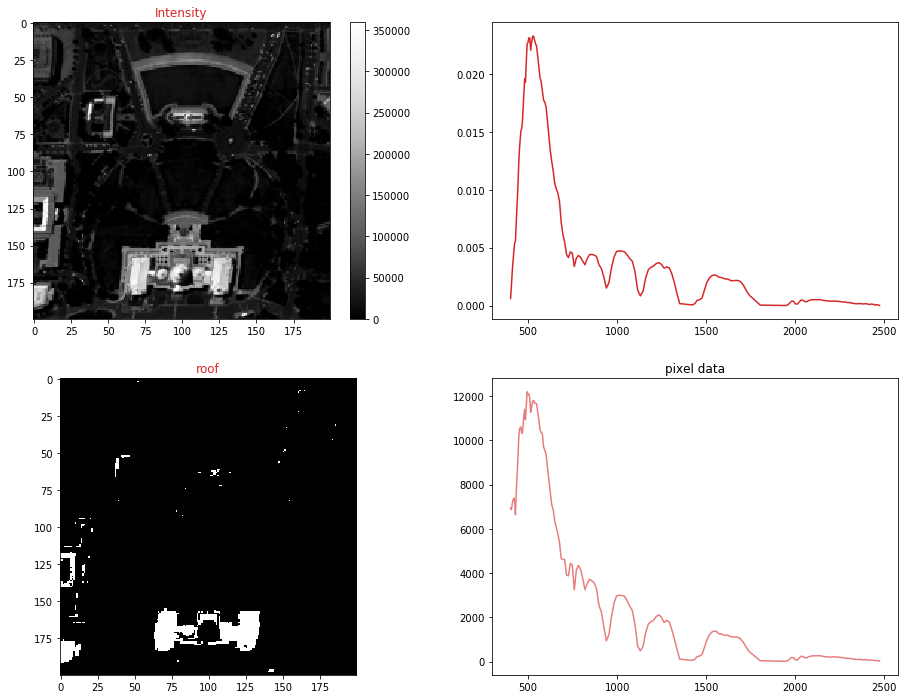

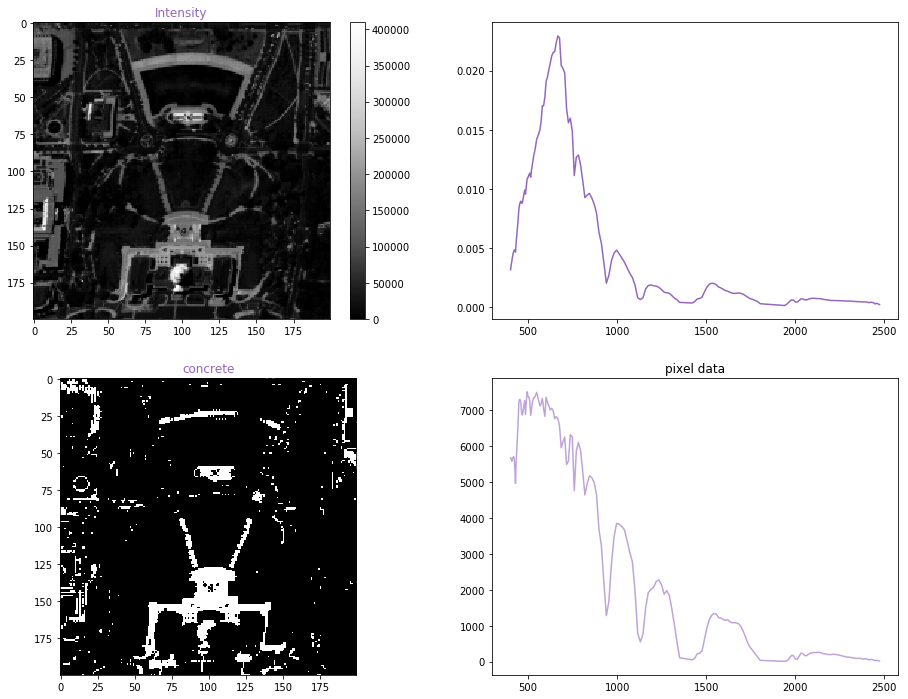

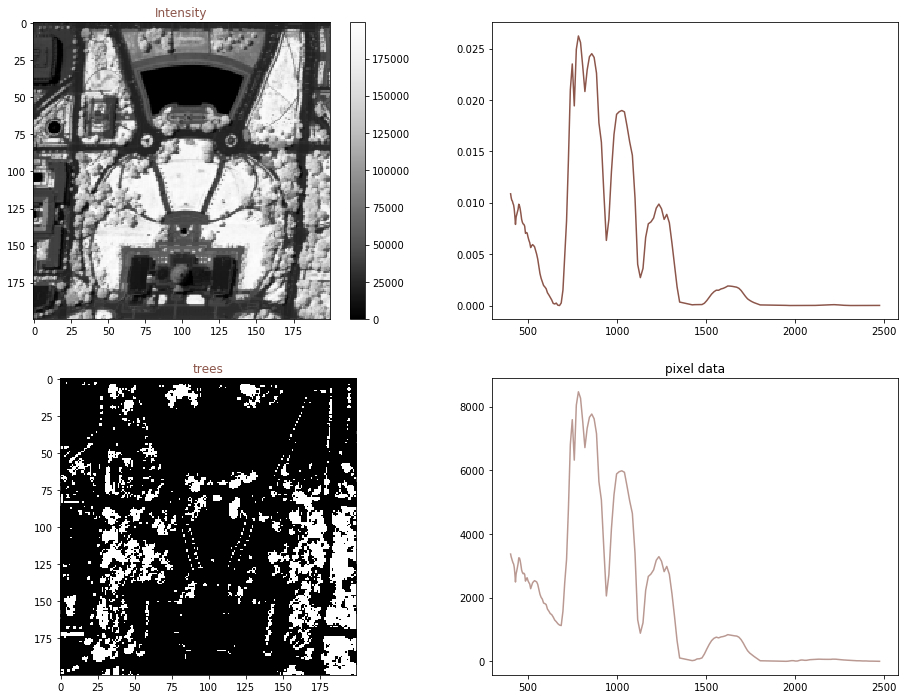

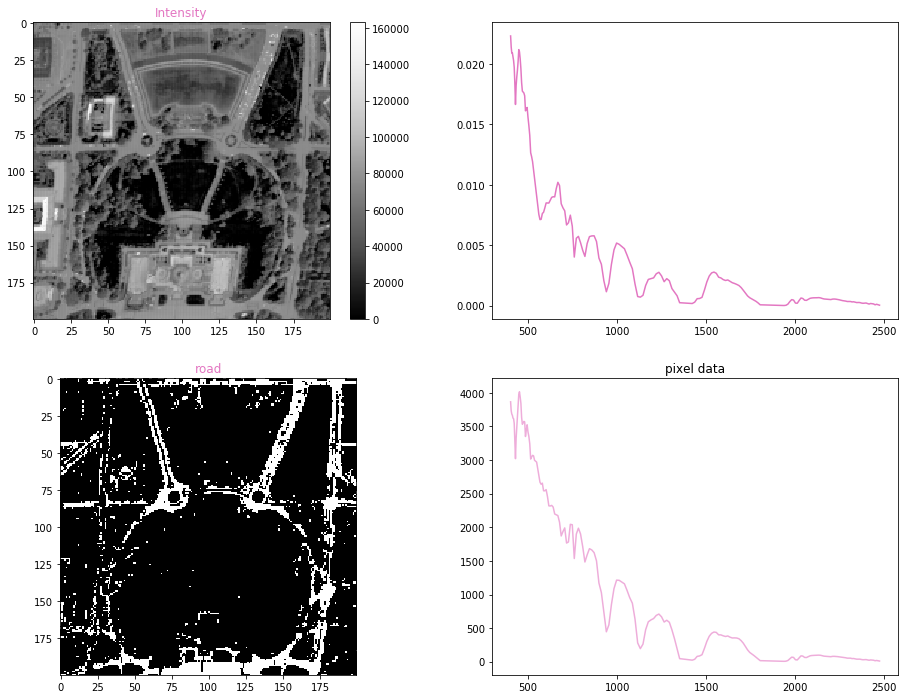

In [10]:
dc.plot_spectra(wavelength, A, points)
dc.compare_likelihood(subset, img_shape, S, points, figsize=(16,6))
dc.plot_objects(subset, A, S, img_shape, points, spectra, wavelength=wavelength)

In [5]:
points = dc.ref_points
A0,S0 = dc.init_nmf(subset, img_shape, points, spectra)

prox_A = proxmin.operators.prox_unity_plus

In [6]:
A, S = nmf.nmf(subset, A0, S0, prox_A, max_iter=100)

INFO:proxmin.algorithms:Completed 1001 iterations


In [12]:
Sn = (S.T/np.max(S,axis=1)).T

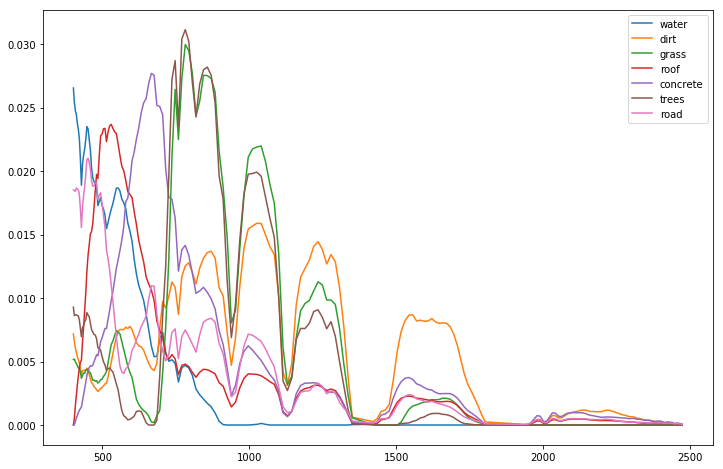

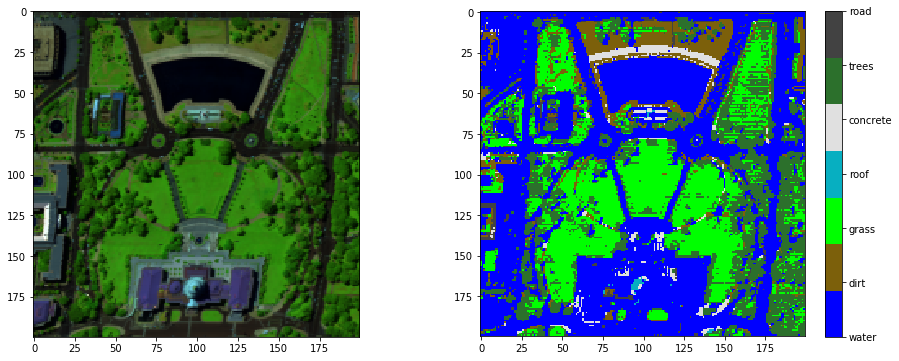

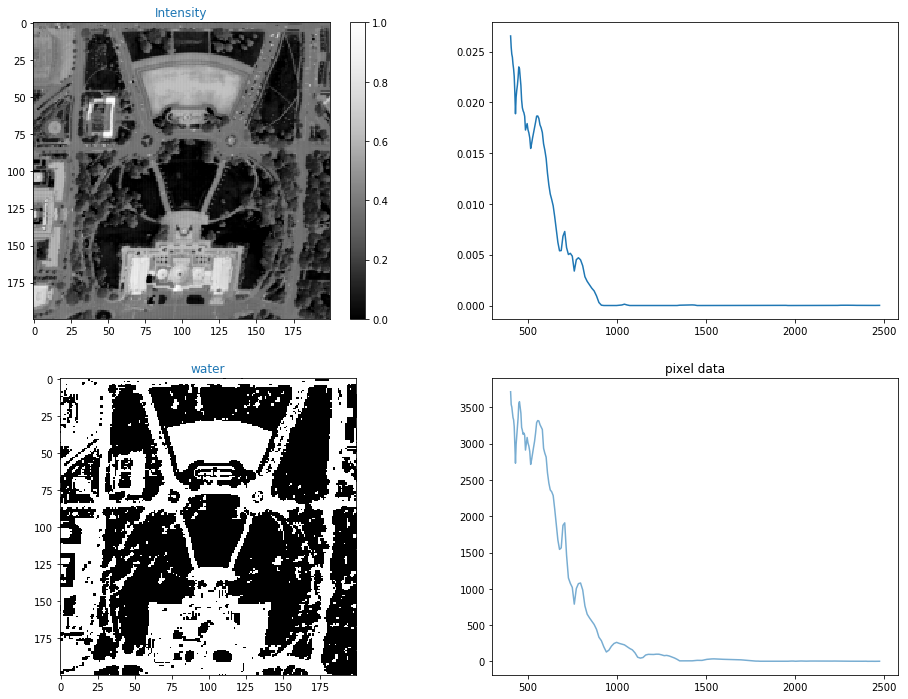

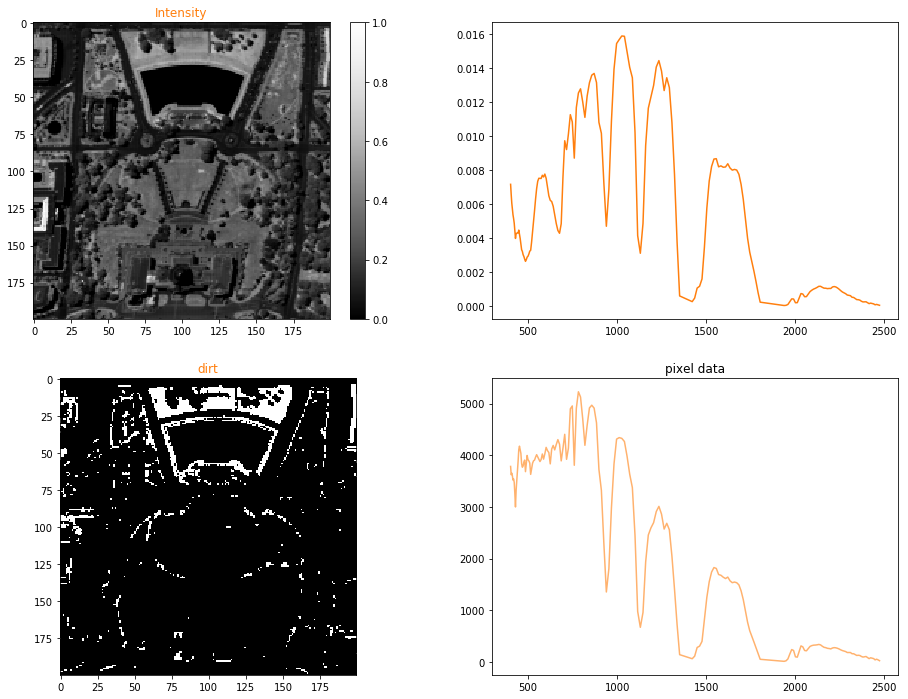

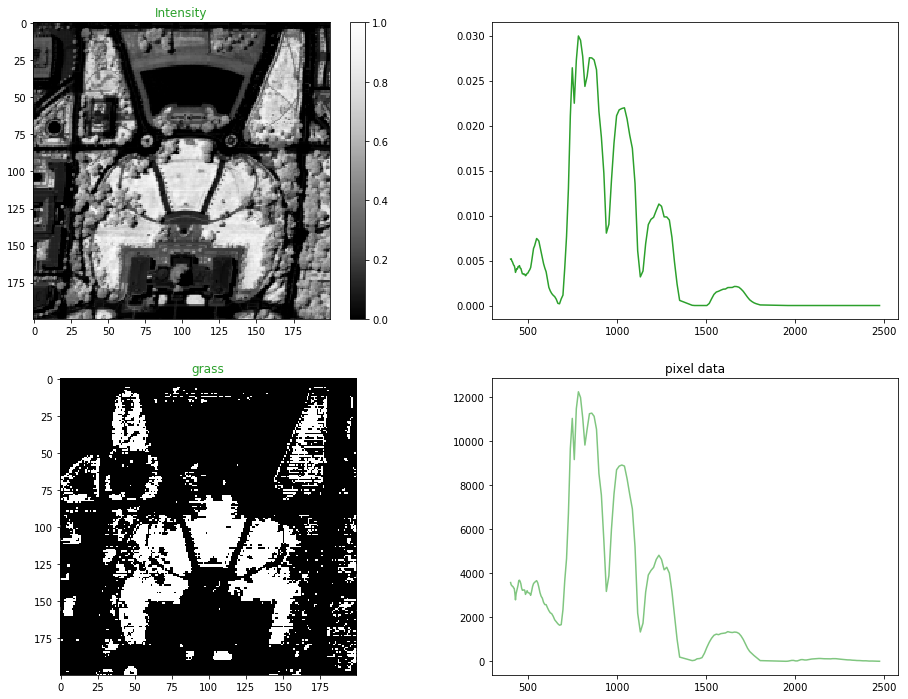

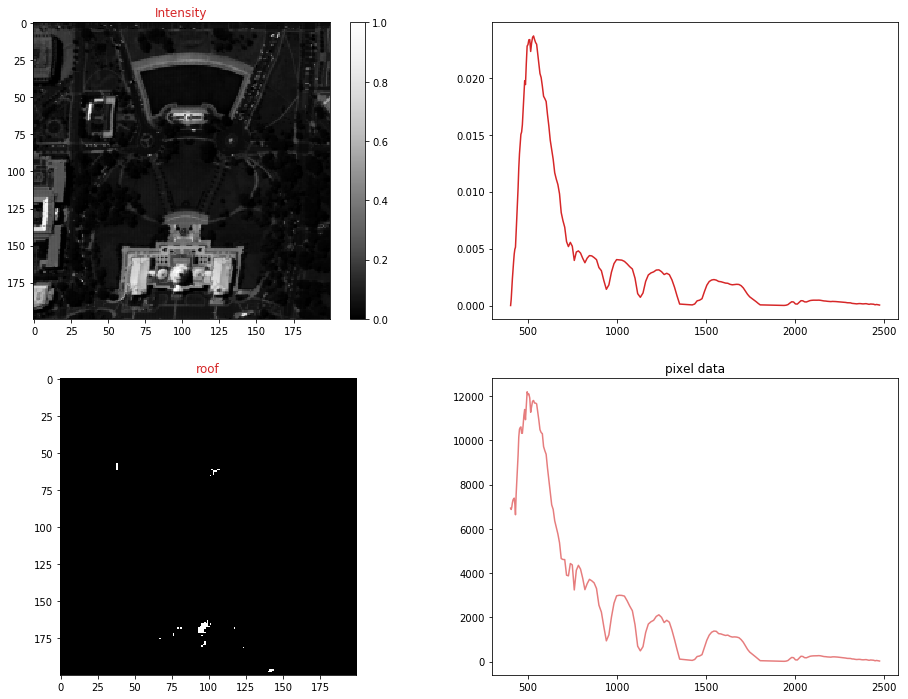

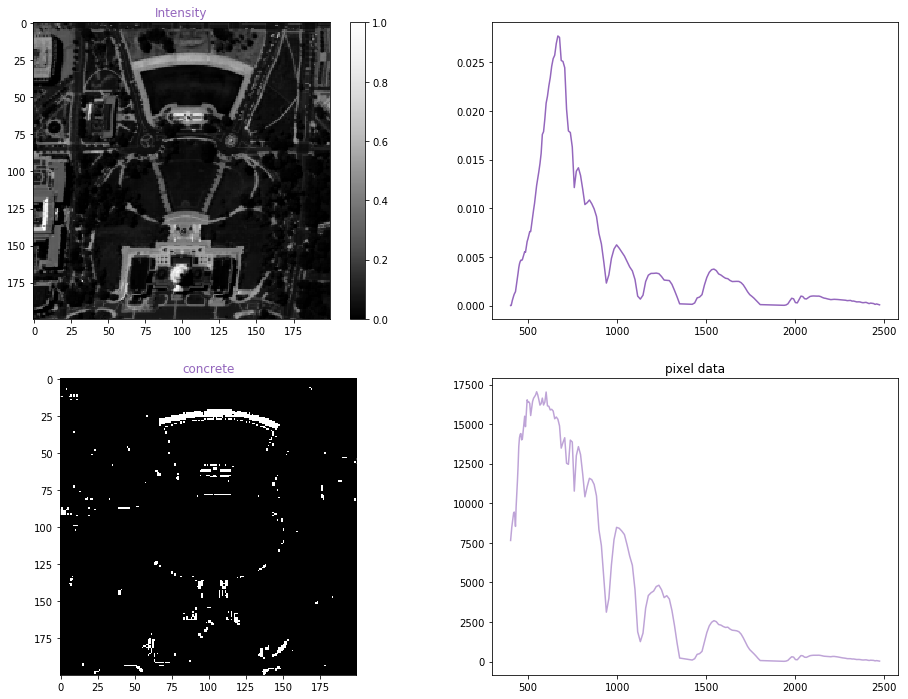

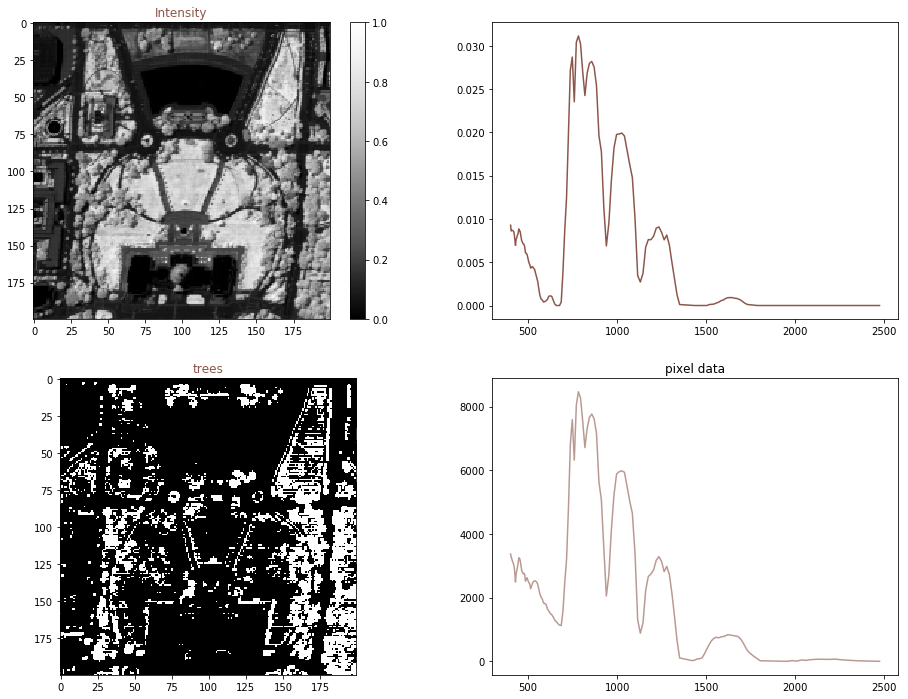

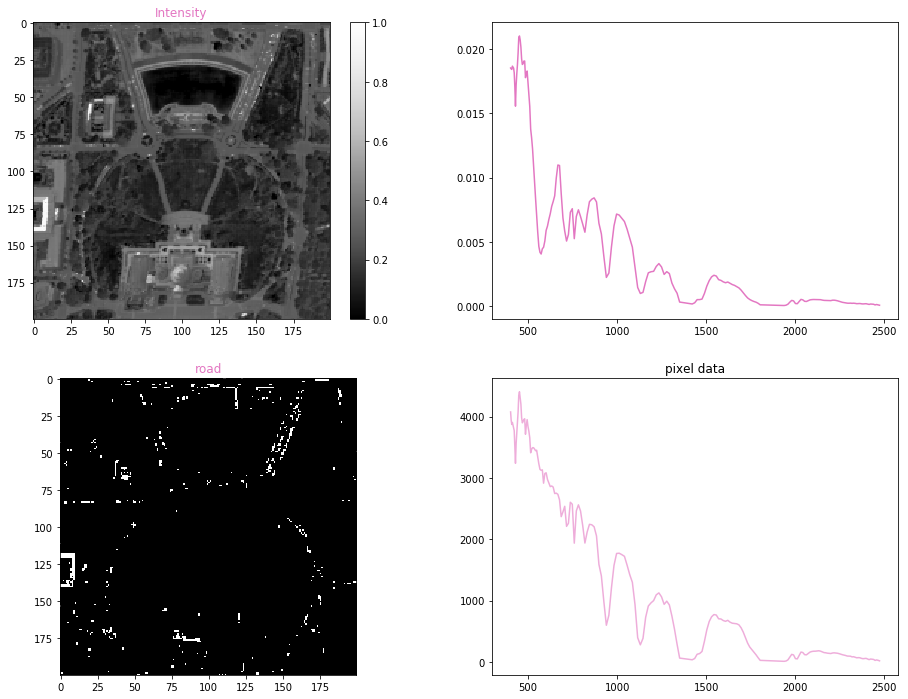

In [13]:
dc.plot_spectra(wavelength, A, points)
dc.compare_likelihood(subset, img_shape, Sn, points, figsize=(16,6))
dc.plot_objects(subset, A, Sn, img_shape, points, spectra, wavelength=wavelength)